In [245]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_distribution, array_to_latex, plot_bloch_multivector
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import pandas as pd

![diagram](./assets/buckshot-roulette-diagram.png)

In [288]:
class Shotgun:
    total_full = 0
    total_blank = 0
    
    def __init__(self, total_full:int, total_blank:int):
        self.total_full = total_full
        self.total_blank = total_blank

    def shoot(self, who:Player) -> str:
        v = self.total_full + self.total_blank

        random_value = np.random.randint(1, v+1)
        shot = random_value <= self.total_full

        if(shot):
            self.total_full -= 1
            who.update_life()
        else:
            self.total_blank -= 1
            
        return "blank" if not shot else "full"

In [289]:
class Player(ABC):
    life = 0
    actions = []
    name = ""

    def __init__(self, name):
        self.name = name
    
    def update_actions(self, last_action:str):
        self.actions.append(last_action)
    
    def update_life(self):
        self.life -= 1

    @property
    def total_life_lost(self) -> int:
        return abs(self.life)
    
    @abstractmethod
    def play(self, gun:Shotgun, removed_blank:int, removed_full:int, oponent:Player) -> (str, int):
        pass

In [290]:
class Person(Player):
    def play(
        self, 
        gun:Shotgun,
        removed_blank:int, 
        removed_full:int, 
        oponent:Player
    ) -> (str, int):
        
        action = None
        result = None
        
        if(removed_blank == 0 and removed_full == 0):
            result = gun.shoot(self)
            action = "himself"
        else:
            result = gun.shoot(oponent)
            action = "shoot"
        
        """
        if(np.random.randint(0,2)):
            result = gun.shoot(oponent)
            action = "shoot"
        else:
            result = gun.shoot(self)
            action = "himself"
        """
        self.update_actions(action)
        return action, result

In [291]:
class Dealer(Player):
    def play(
        self, 
        gun:Shotgun,
        removed_blank:int, 
        removed_full:int, 
        oponent:Player
    ) -> str:

        action = None
        result = None
        
        if(np.random.randint(0,2)):
            result = gun.shoot(oponent)
            action = "shoot"
        else:
            result = gun.shoot(self)
            action = "himself"
        self.update_actions(action)
        return action, result

In [293]:
class Game:
    gun = None
    removed_blank = 0
    removed_full = 0
    total_full = 0
    total_blan = 0
    total_rounds = 0
    player = None 
    dealer = None 
    next_player = None
    n = 0
    statistics = pd.DataFrame(columns=("player_win", "dealer_win", "total_rounds"))
    
    
    def __init__(self, n:int, total_full:int, total_blank:int):
        self.total_full = total_full
        self.total_blank = total_blank
        self.total_rounds = total_full+total_blank
        self.n = n
        self.statistics.reset_index()

    def start_actors(self):
        self.gun = Shotgun(self.total_full, self.total_blank)
        self.player = Person("player")
        self.dealer = Dealer("dealer")
        self.next_player = self.player
        

    def run_game(self) -> pd.DataFrame:
        for i in range(self.n):
            self.start_actors()
            for round in range(self.total_rounds):
                #print(f"round {round}: ", end=" ")
                action, result = self.next_player.play(self.gun, self.removed_blank, self.removed_full, self.get_oponent())
    
                if(result == "blank"):
                    self.removed_blank += 1
                else:
                    self.removed_full += 1
                
                #print(f"{self.next_player.name} --> {action}, {result}")
    
                if(action != "himself"):
                    self.next_player = self.get_oponent()
                #print(self.player.total_life_lost, self.dealer.total_life_lost, self.total_full)
                
                if(self.player.total_life_lost == self.total_full):
                    #print("dealer wins")
                    self.statistics.loc[i] = {'dealer_win':1, 'player_win':0, 'total_rounds':round}                    
                    break
                elif(self.dealer.total_life_lost == self.total_full):
                    #print("player wins")
                    self.statistics.loc[i] = {'dealer_win':0, 'player_win':1, 'total_rounds':round}                    
                    break
            #print()
        return self.statistics
            

    def get_oponent(self):
        if(self.next_player == self.player):
            return self.dealer
        else:
            return self.player

results = Game(1000, 1,2).run_game()
results.head()

,player_win,dealer_win,total_rounds
0,0,1,0
1,1,0,0
2,1,0,2
3,1,0,0
4,1,0,0


In [296]:
print(len(results[results['player_win'] == 1]), len(results[results['dealer_win'] == 1]))

745 255


In [317]:
def compare_results(n):
    df = pd.DataFrame(columns=("player_total_wins", "dealer_total_wins"))
    df.reset_index()
    for i in range(n):
        result = Game(100, 1, 2).run_game()
        df.loc[i] = {"player_total_wins":len(results[results['player_win'] == 1]), "dealer_total_wins":len(results[results['dealer_win'] == 1])}
    
    plt.plot(df)
    plt.legend(df.columns, loc="upper right")
    plt.show()

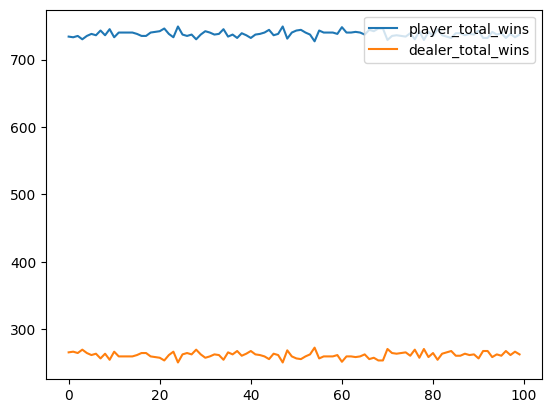

In [320]:
compare_results(100)